In [1]:
!pip install torch torchvision pandas numpy scikit-learn matplotlib pillow


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
import matplotlib.pyplot as plt
import time
import os

class CenterNet(nn.Module):
    def __init__(self, num_classes):
        super(CenterNet, self).__init__()
        self.num_classes = num_classes
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512)
        )
        
        self.fc = None
        self._initialize_fc_layer()

    def _initialize_fc_layer(self):
        dummy_input = torch.zeros(1, 3, 256, 256)
        with torch.no_grad():
            dummy_output = self.backbone(dummy_input)
            num_features = dummy_output.numel() // dummy_output.size(0)
            self.fc = nn.Sequential(
                nn.Linear(num_features, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, self.num_classes)
            )
    
    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class PCBComponentDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        labels = self.annotations.iloc[idx, 1:].values.astype('float')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(labels)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

def load_class_names(csv_file):
    df = pd.read_csv(csv_file)
    class_names = df.columns[1:].tolist()
    return class_names

class_names = load_class_names('./Centernet/train/_classes.csv')

train_dataset = PCBComponentDataset(
    csv_file='./Centernet/train/_classes.csv',
    root_dir='./Centernet/train',
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = PCBComponentDataset(
    csv_file='./Centernet/valid/_classes.csv',
    root_dir='./Centernet/valid',
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = PCBComponentDataset(
    csv_file='./Centernet/test/_classes.csv',
    root_dir='./Centernet/test',
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [3]:
model = CenterNet(num_classes=16)  # Adjust num_classes based on your dataset
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 9:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3f}")
            running_loss = 0.0

print("Finished Training")

[1, 10] loss: 0.858
[1, 20] loss: 0.635
[1, 30] loss: 0.463
[1, 40] loss: 0.448
[1, 50] loss: 0.436
[1, 60] loss: 0.468
[2, 10] loss: 0.390
[2, 20] loss: 0.402
[2, 30] loss: 0.431
[2, 40] loss: 0.412
[2, 50] loss: 0.390
[2, 60] loss: 0.391
[3, 10] loss: 0.333
[3, 20] loss: 0.348
[3, 30] loss: 0.357
[3, 40] loss: 0.391
[3, 50] loss: 0.375
[3, 60] loss: 0.360
[4, 10] loss: 0.282
[4, 20] loss: 0.294
[4, 30] loss: 0.286
[4, 40] loss: 0.320
[4, 50] loss: 0.350
[4, 60] loss: 0.290
[5, 10] loss: 0.263
[5, 20] loss: 0.238
[5, 30] loss: 0.254
[5, 40] loss: 0.238
[5, 50] loss: 0.261
[5, 60] loss: 0.221
[6, 10] loss: 0.150
[6, 20] loss: 0.199
[6, 30] loss: 0.187
[6, 40] loss: 0.201
[6, 50] loss: 0.189
[6, 60] loss: 0.188
[7, 10] loss: 0.118
[7, 20] loss: 0.108
[7, 30] loss: 0.113
[7, 40] loss: 0.133
[7, 50] loss: 0.135
[7, 60] loss: 0.127
[8, 10] loss: 0.089
[8, 20] loss: 0.098
[8, 30] loss: 0.076
[8, 40] loss: 0.078
[8, 50] loss: 0.097
[8, 60] loss: 0.078
[9, 10] loss: 0.062
[9, 20] loss: 0.059


In [4]:
def calculate_iou(preds, labels):
    intersection = np.logical_and(labels, preds)
    union = np.logical_or(labels, preds)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    return iou


In [5]:

def evaluate_model(loader, model, dataset_name="Dataset"):
    model.eval()
    all_labels = []
    all_preds = []
    inference_times = []

    with torch.no_grad():
        for inputs, labels in loader:
            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()

            preds = (outputs > 0.5).float()
            inference_times.append(end_time - start_time)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    precision = precision_score(all_labels, all_preds, average='micro')
    recall = recall_score(all_labels, all_preds, average='micro')
    f1 = f1_score(all_labels, all_preds, average='micro')
    ap = average_precision_score(all_labels, all_preds, average='micro')
    iou = calculate_iou(all_preds, all_labels)

    mean_inference_time = np.mean(inference_times)
    fps = 1.0 / mean_inference_time

    print(f"Metrics for {dataset_name}:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Average Precision (AP): {ap:.3f}")
    print(f"Mean Average Precision (mAP): {ap:.3f}")  # Using AP as mAP for simplicity
    print(f"IoU: {iou:.3f}")
    print(f"Inference Time: {mean_inference_time:.3f} seconds")
    print(f"FPS: {fps:.3f}\n")

    return precision, recall, f1, ap, iou, mean_inference_time, fps

val_metrics = evaluate_model(val_loader, model, dataset_name="Validation Dataset")
test_metrics = evaluate_model(test_loader, model, dataset_name="Test Dataset")

Metrics for Validation Dataset:
Precision: 0.724
Recall: 0.515
F1 Score: 0.602
Average Precision (AP): 0.485
Mean Average Precision (mAP): 0.485
IoU: 0.431
Inference Time: 0.151 seconds
FPS: 6.637

Metrics for Test Dataset:
Precision: 0.688
Recall: 0.500
F1 Score: 0.579
Average Precision (AP): 0.454
Mean Average Precision (mAP): 0.454
IoU: 0.408
Inference Time: 0.144 seconds
FPS: 6.968



In [6]:
torch.save(model.state_dict(), 'centernet_model.pth')
print("Model saved as 'centernet_model.pth'")

Model saved as 'centernet_model.pth'


In [7]:
import torch
import pandas as pd
from tqdm import tqdm

# Example class names
class_names = [
    "IC", "LED", "battery", "buzzer", "capacitor", "clock", "connector",
    "diode", "display", "fuse", "inductor", "potentiometer", "relay",
    "resistor", "switch", "transistor"
]

# Initialize an empty list to collect results
results = []

# Function to process each batch and extract results
def process_batch(batch_results):
    return batch_results.numpy()  # Convert to numpy array directly

# Function to count detections for each class
def count_detections(scores, threshold=0.5):
    counts = {class_name: 0 for class_name in class_names}
    for score in scores:
        if score > threshold:  # Apply a threshold to consider a detection
            class_idx = int(score.argmax())  # Get the index of the highest score
            counts[class_names[class_idx]] += 1
    return counts

# Assume `test_loader` is your DataLoader for the test dataset
for images, targets in tqdm(test_loader, desc="Processing Batches"):
    # Assuming model inference or similar operation returns the results
    with torch.no_grad():
        outputs = model(images)  # Replace with actual model inference
        
        if isinstance(outputs, torch.Tensor):
            batch_results = outputs
        elif isinstance(outputs, dict) and 'scores' in outputs:
            batch_results = outputs['scores']
        else:
            raise ValueError("Unexpected output format from the model")
    
    # Check if `batch_results` has the right shape
    if batch_results.shape[0] != len(images):
        print(f"Warning: Batch results shape {batch_results.shape} does not match number of images in the batch {len(images)}")

    # Process the batch results
    batch_results_np = process_batch(batch_results)
    for image_idx, result in enumerate(batch_results_np):
        # Count detections for this image
        counts = count_detections(result)
        counts['image_idx'] = len(results)  # Add an index to track image order
        results.append(counts)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save DataFrame to CSV
results_df.to_csv("test_results.csv", index=False)

print(f"Results shape: {results_df.shape}")
print(f"Test results saved to test_results.csv")


Processing Batches: 100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Results shape: (142, 17)
Test results saved to test_results.csv


In [8]:
import torch.nn.utils.prune as prune

def prune_model(model, amount=0.2):
    # Apply pruning to the model
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name="weight", amount=amount)
    return model

# Apply pruning
pruned_model = prune_model(CenterNet(num_classes=16), amount=0.2)


In [9]:
import torch.quantization as quant

def prepare_and_convert_for_quantization(model):
    # Prepare the model for quantization
    model.train()  # Important for preparing quantization
    model = quant.prepare(model, inplace=False)
    # Run a calibration pass on a sample batch
    for images, _ in train_loader:
        model(images)
        break
    model = quant.convert(model, inplace=False)
    return model

# Apply quantization
quantized_model = prepare_and_convert_for_quantization(CenterNet(num_classes=16))


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/ao/quantization/quantize.py:312: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn("None of the submodule got qconfig applied. Make sure you "


In [10]:
# Define a function to evaluate a model
def evaluate_model_with_metrics(loader, model, dataset_name="Dataset"):
    model.eval()
    all_labels = []
    all_preds = []
    inference_times = []

    with torch.no_grad():
        for inputs, labels in loader:
            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()

            preds = (outputs > 0.5).float()
            inference_times.append(end_time - start_time)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    precision = precision_score(all_labels, all_preds, average='micro')
    recall = recall_score(all_labels, all_preds, average='micro')
    f1 = f1_score(all_labels, all_preds, average='micro')
    ap = average_precision_score(all_labels, all_preds, average='micro')
    iou = calculate_iou(all_preds, all_labels)

    mean_inference_time = np.mean(inference_times)
    fps = 1.0 / mean_inference_time

    print(f"Metrics for {dataset_name}:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Average Precision (AP): {ap:.3f}")
    print(f"Mean Average Precision (mAP): {ap:.3f}")  # Using AP as mAP for simplicity
    print(f"IoU: {iou:.3f}")
    print(f"Inference Time: {mean_inference_time:.3f} seconds")
    print(f"FPS: {fps:.3f}\n")

    return precision, recall, f1, ap, iou, mean_inference_time, fps


In [11]:
# Evaluate raw model
print("Evaluating raw model...")
raw_val_metrics = evaluate_model_with_metrics(val_loader, model, dataset_name="Validation Dataset")
raw_test_metrics = evaluate_model_with_metrics(test_loader, model, dataset_name="Test Dataset")

# Evaluate pruned model
print("Evaluating pruned model...")
pruned_val_metrics = evaluate_model_with_metrics(val_loader, pruned_model, dataset_name="Validation Dataset")
pruned_test_metrics = evaluate_model_with_metrics(test_loader, pruned_model, dataset_name="Test Dataset")

# Evaluate quantized model
print("Evaluating quantized model...")
quantized_val_metrics = evaluate_model_with_metrics(val_loader, quantized_model, dataset_name="Validation Dataset")
quantized_test_metrics = evaluate_model_with_metrics(test_loader, quantized_model, dataset_name="Test Dataset")


Evaluating raw model...
Metrics for Validation Dataset:
Precision: 0.724
Recall: 0.515
F1 Score: 0.602
Average Precision (AP): 0.485
Mean Average Precision (mAP): 0.485
IoU: 0.431
Inference Time: 0.148 seconds
FPS: 6.745

Metrics for Test Dataset:
Precision: 0.688
Recall: 0.500
F1 Score: 0.579
Average Precision (AP): 0.454
Mean Average Precision (mAP): 0.454
IoU: 0.408
Inference Time: 0.153 seconds
FPS: 6.546

Evaluating pruned model...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Validation Dataset:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Average Precision (AP): 0.232
Mean Average Precision (mAP): 0.232
IoU: 0.000
Inference Time: 0.169 seconds
FPS: 5.920



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Test Dataset:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Average Precision (AP): 0.219
Mean Average Precision (mAP): 0.219
IoU: 0.000
Inference Time: 0.167 seconds
FPS: 5.982

Evaluating quantized model...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Validation Dataset:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Average Precision (AP): 0.232
Mean Average Precision (mAP): 0.232
IoU: 0.000
Inference Time: 0.127 seconds
FPS: 7.856

Metrics for Test Dataset:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Average Precision (AP): 0.219
Mean Average Precision (mAP): 0.219
IoU: 0.000
Inference Time: 0.118 seconds
FPS: 8.443



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
def print_comparison_summary():
    print("Performance Comparison:")
    print("\nRaw Model:")
    print(f"Validation Metrics: {raw_val_metrics}")
    print(f"Test Metrics: {raw_test_metrics}")

    print("\nPruned Model:")
    print(f"Validation Metrics: {pruned_val_metrics}")
    print(f"Test Metrics: {pruned_test_metrics}")

    print("\nQuantized Model:")
    print(f"Validation Metrics: {quantized_val_metrics}")
    print(f"Test Metrics: {quantized_test_metrics}")

print_comparison_summary()


Performance Comparison:

Raw Model:
Validation Metrics: (0.7236315086782377, 0.5152091254752852, 0.6018878400888397, 0.48545406558639836, 0.43050039714058774, 0.14824971887800428, 6.745375354289251)
Test Metrics: (0.6878453038674033, 0.5, 0.5790697674418605, 0.4535177223562369, 0.4075286415711948, 0.15275584326850045, 6.54639442003073)

Pruned Model:
Validation Metrics: (0.0, 0.0, 0.0, 0.23233215547703182, 0.0, 0.16891307300991482, 5.920204885155942)
Test Metrics: (0.0, 0.0, 0.0, 0.21919014084507044, 0.0, 0.1671726173824734, 5.981840899889154)

Quantized Model:
Validation Metrics: (0.0, 0.0, 0.0, 0.23233215547703182, 0.0, 0.12728578514522976, 7.856336816079079)
Test Metrics: (0.0, 0.0, 0.0, 0.21919014084507044, 0.0, 0.11844449573092991, 8.442773079735995)


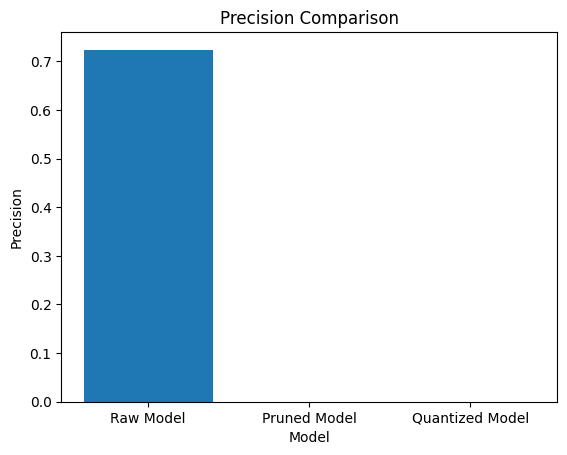

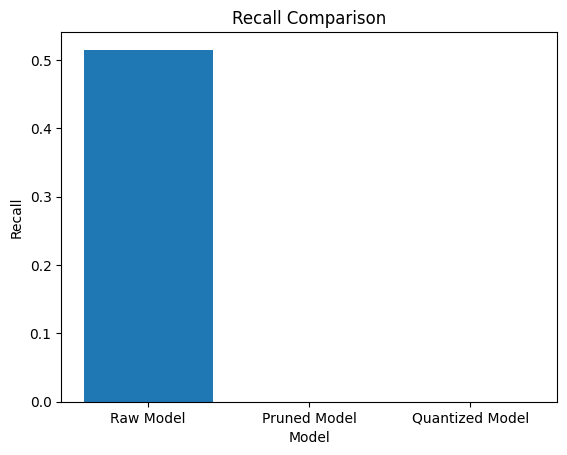

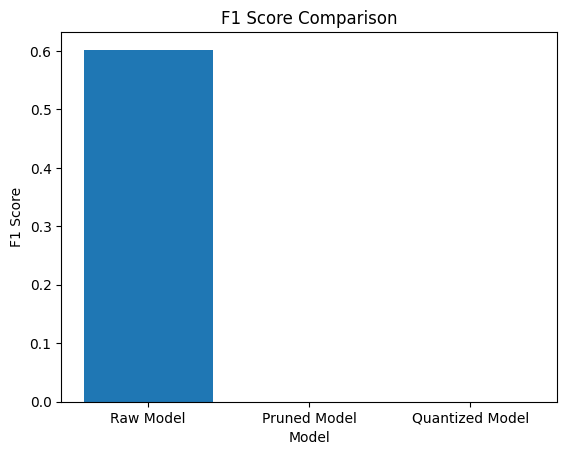

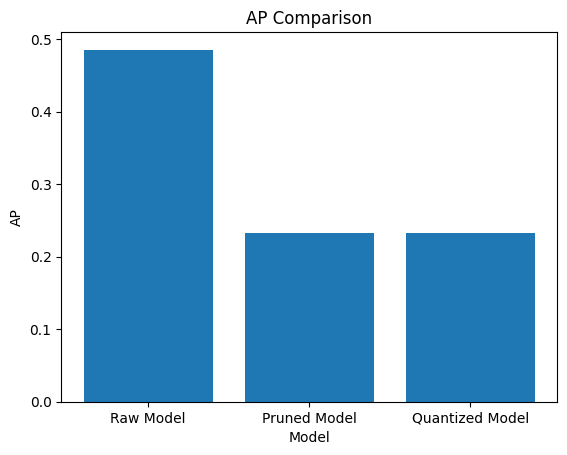

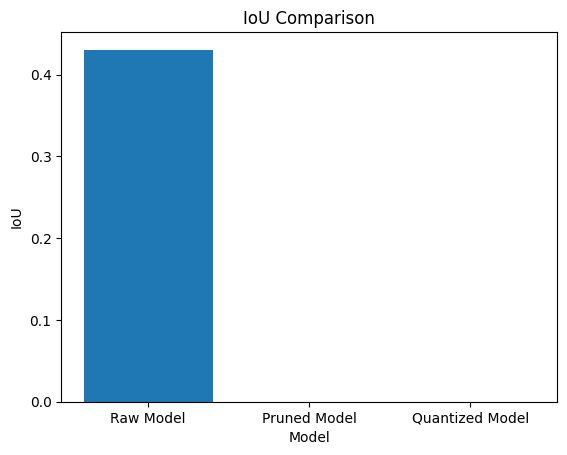

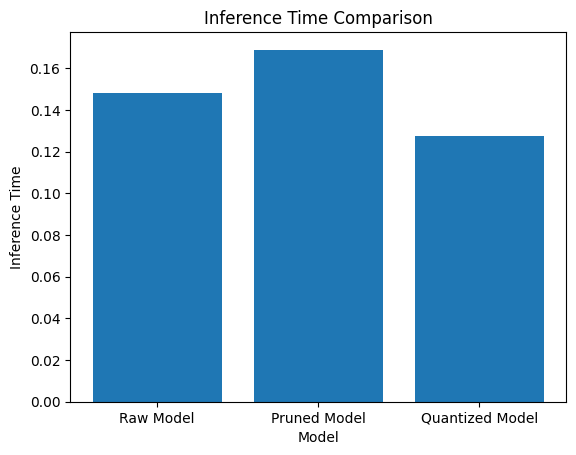

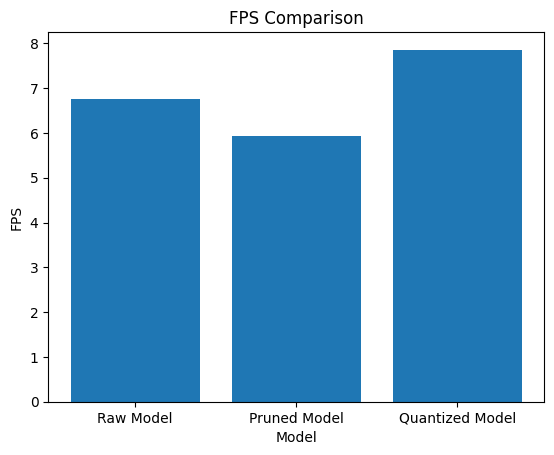

In [13]:
def plot_metrics(metrics_list, labels):
    metrics = ['Precision', 'Recall', 'F1 Score', 'AP', 'IoU', 'Inference Time', 'FPS']
    for i, metric in enumerate(metrics):
        plt.figure()
        plt.bar(labels, [metrics_list[j][i] for j in range(len(labels))])
        plt.title(f'{metric} Comparison')
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.show()

metrics_list = [raw_val_metrics, pruned_val_metrics, quantized_val_metrics]
labels = ['Raw Model', 'Pruned Model', 'Quantized Model']
plot_metrics(metrics_list, labels)
